# Hierarchical Clustering



In [1]:
"""Implements the cluster class."""

import copy
import math


class Cluster:
    """A cluster to be used for the hierarchical clusterization.

    :ivar int _dimensions: Holds the dimensions of each point in the cluster.
    :ivar set _points: A set with the points of the cluster.
    :ivar tuple [float] _centroid: Memoize the centroid of the cluster.
    """

    _dimensions = None
    _centroid = None
    _points = None

    def __init__(self, *coordinates):
        """Initializer.

        Note that a cluster cannot be empty, meaning it must contain at least
        one point; this is why if no coordinates will be passed an exception
        will be raised. For the whole lifespan of the instance any point that
        will be added must have the dimensions as the initial.

        :param coordinates: A tuple holding the coordinates of the point to add.
        """
        assert coordinates, "You must pass valid coordinates."
        self._points = set()
        self.add_point(*coordinates)

    def get_features(self, index):
        """Returns the features for the passed in index.

        Example:

        Assuming that your points look like this:
                    [1, 3, 4]
                    [2, 7, 11]
        meaning that they represent three-dimensional data points (x, y, z)
        then passing an index of 0 we will get back the vector <1, 2> while
        for 1 <3, 7> etc.

        :param int index: The index of the features to return.

        :return: A list of doubles representing the features for a specific
        dimension.

        :rtype: list[float]
        """
        return [p[index] for p in self._points]


    def __eq__(self, other):
        """Checks if the passed in cluster has the same points.

        :param Cluster other: The other instance to check.
        :rtype: bool.
        """
        return len(self._points.difference(other._points)) == 0 and len(
            self._points) == len(other._points)

    def __contains__(self, point):
        """Checks is the passed in point is contained in the cluster.

        :param tuple point: The point to check if it is contained.

        :return: True if the point is contained.
        :rtype: bool.
        """
        return point in self._points

    def __len__(self):
        """Returns the number of points in the cluster.

        :return: The number of points in the cluster.
        :rtype: int.
        """
        return len(self._points)

    def add_point(self, *coordinates):
        """Adds a point to the cluster.

        A point is represented as a tuple of floats; the very first time
        this method is called the number of the coordinates will characterize
        the dimensions of each point for the whole lifespan of the instance.

        :param coordinates: A tuple holding the coordinates of the point to add.
        """
        self._centroid = None  # Will force a recalculation of centroid.
        if self._dimensions is None:
            assert len(self._points) == 0
            self._dimensions = len(coordinates)
        assert len(coordinates) == self._dimensions
        assert coordinates not in self._points
        self._points.add(coordinates)

    def get_distance(self, other):
        """Returns the EuclideanDistance to the passed in Cluster.

        Uses the average distance for all the points. Note that there are
        other ways to specify the distance but since this class is meant
        for educational purposes it only supports one distance approach.

        :param Cluster other: The cluster to return the distance.

        :return: The EuclideanDistance between this instance and the passed
        in other instance.

        :rtype: float.
        """
        point_1 = self.get_centroid()
        point_2 = other.get_centroid()
        return self.get_euclidean_distance(point_1, point_2)

    def get_centroid(self):
        """Calculates and returns the centroid of the cluster.

        For a small performance gain the centroid is memoized until
        a new point will be added.

        :return: The centroid point as a tuple of floats.
        :rtype: tuple[float].
        """
        if self._centroid is None:
            assert len(self._points) > 0
            totals = [0] * self._dimensions
            for point in self._points:
                for dim in range(self._dimensions):
                    totals[dim] += point[dim]
            self._centroid = tuple([t / len(self._points) for t in totals])
        return self._centroid

    @classmethod
    def get_euclidean_distance(cls, p1, p2):
        """Calculates the euclidean distance for the passed in points.

        :return: The EuclideanDistance between the passed in points.
        :rtype: float.
        """
        assert len(p1) == len(p2)
        result = 0.0
        for i in range(len(p1)):
            result += pow(float(p1[i]) - float(p2[i]), 2)
        return math.sqrt(result)

    @classmethod
    def merge(cls, cluster_1, cluster_2):
        """Merges the passed in clusters to a new cluster.

        :param Cluster cluster_1: The first cluster to merge.
        :param Cluster cluster_2: The second cluster to merge.

        :return: A new cluster containing all the points for both clusters.
        :rtype: Cluster.
        """
        assert cluster_1._dimensions == cluster_2._dimensions

        new_cluster = copy.deepcopy(cluster_1)
        new_cluster._points.update(cluster_2._points)
        return new_cluster


In [11]:
"""Implements the ClusterPair class."""
class ClusterPair:
    """A utility class simplifying the heapify process."""

    def __init__(self, cluster_1, cluster_2):
        """Initializer.

        :param Cluster cluster_1: The first cluster of the pair.
        :param Cluster cluster_2: The second cluster of the pair.
        """
        self._distance = cluster_1.get_distance(cluster_2)
        self._cluster_1 = cluster_1
        self._cluster_2 = cluster_2

    def contains_cluster(self, cluster_to_check):
        """Returns true if the passed in cluster is in the pair.

        :param Cluster cluster_to_check: The cluster to check.

        :return: True if the passed in cluster is in the pair.
        :rtype: bool.
        """
        return (
                cluster_to_check == self._cluster_1 or
                cluster_to_check == self._cluster_2
        )

    def overlaps(self, other):
        """Checks whether other is overlapping with this.

        :param ClusterPair other: The pair to check for overlapping.

        :return: True if other is overlapping with this.
        :rtype: bool.
        """
        if other._cluster_1 == self._cluster_1:
            return True

        if other._cluster_1 == self._cluster_2:
            return True

        if other._cluster_2 == self._cluster_1:
            return True

        if other._cluster_2 == self._cluster_2:
            return True

        return False

    def merge(self):
        """Merges the paired clusters into a new one.

        :return: A new cluster holding all the points for the pair.
        :rtype: Cluster.
        """
        return Cluster.merge(self._cluster_1, self._cluster_2)

    def __contains__(self, point):
        """Checks is the passed in point is contained in the cluster pair.

        :param tuple point: The point to check if it is contained.

        :return: True if the point is contained.
        :rtype: bool.
        """
        return point in self._cluster_1 or point in self._cluster_2

    def __lt__(self, other):
        """Checks if the distance of other is larger or not.

        :param ClusterPair other: The other pair to compare its distance.

        :return: True if the distance of this pair is smalller than the other's.
        :rtype: bool.
        """
        return self._distance < other._distance

    def __repr__(self):
        """Programmer friendly representation of the instance."""
        return f'ClusterPair with distance: {self._distance}'

In [12]:
"""Implements the make clusters function."""

import heapq
import itertools


def make_clusters(points, no_clusters=2, verbose=False):
    """Creates the clusters for the passed in points.

    :param list[tuple] points: The points to clusterize; all of them must
    have the same dimensions.

    :param int no_clusters: The number of clusters to make.

    :param bool verbose: If true it will print debugging messages.

    :return: A list of Cluster instances.
    :rtype: list[Cluster]
    """
    _validate_points(points)
    clusters = [Cluster(*p) for p in points]

    pairs = [
        ClusterPair(c1, c2) for c1, c2 in itertools.combinations(clusters, 2)
    ]

    heapq.heapify(pairs)

    while len(clusters) > no_clusters:
        if verbose:
            print(len(clusters))
        best_pair = heapq.heappop(pairs)

        # Remove all the pairs overlapping with the best pair.
        pairs = [p for p in pairs if not p.overlaps(best_pair)]

        # Remove all the clusters that will be merged.
        clusters = [c for c in clusters if not best_pair.contains_cluster(c)]

        # Create the new cluster.
        new_cluster = best_pair.merge()

        # Add the pairs for the new_cluster.
        for c in clusters:
            pairs.append(ClusterPair(c, new_cluster))

        heapq.heapify(pairs)
        # Add the new cluster to the active clusters.
        clusters.append(new_cluster)
    return clusters


def _validate_points(points):
    """Validates that all points have the same dimensions.

    :raises: AssertionError.
    """
    assert len(points) >= 1
    dimensions = len(points[0])
    for p in points:
        assert dimensions == len(p)

In [16]:
import itertools
import matplotlib.pyplot as plt
import csv

In [17]:
points = []
with open("../data/data-pca.csv", 'r') as f:
    for index, tokens in enumerate(csv.reader(f)):
        if index > 0:
            points.append(tuple([float(t) for t in tokens[:-1]]))
clust = make_clusters(points, no_clusters=2)

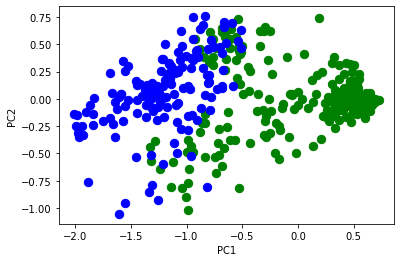

In [18]:
#Prints the resulting figure for PC1 and PC2
colors =['green', 'blue' ]
for index, c in enumerate(clust):
    X = c.get_features(0)
    Y = c.get_features(1)
    plt.scatter(X, Y, s = 70, c=colors[index])
    plt.xlabel('PC1')
    plt.ylabel('PC2')
plt.show()